<a href="https://colab.research.google.com/github/GeronimoQB/CT_Algoritmos/blob/main/5_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering de datos de volumen forestal (Colab)

Este notebook realiza un análisis de **clustering no supervisado** usando `K-Means` con **10 clusters** sobre el archivo `volume.xlsx`.

Variables utilizadas para el agrupamiento:

- `diameter`
- `height`
- `density`
- `basal_area`
- `volume`

⚠️ **Importante:** En Google Colab, sube primero el archivo `volume.xlsx` al entorno de ejecución (o monta Google Drive) antes de ejecutar las celdas.

## 0. Configuración inicial en Colab

Ejecuta esta celda si vas a trabajar con archivos en tu Google Drive.
Si prefieres subir directamente `volume.xlsx`, puedes omitir el montaje y usar `Archivos → Subir`.

In [ ]:
# Ejecuta esto solo si quieres montar tu Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Si usas Drive, ajusta la ruta más abajo, por ejemplo:
path = '/content/drive/MyDrive/Curso-Taller_Algoritmos/data/volume.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Importar librerías

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, MiniBatchKMeans

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (7, 5)
sns.set(style='whitegrid')

## 2. Carga y exploración de datos

Asegúrate de que el archivo `volume.xlsx` esté disponible en la ruta indicada.

In [ ]:
# Ruta al archivo
path = '/content/drive/MyDrive/Curso-Taller_Algoritmos/data/volume.xlsx'  # ajusta si usas Google Drive

df = pd.read_excel(path)

print('Dimensiones del dataset:', df.shape)
df.head()

Dimensiones del dataset: (16251, 7)


,plot,diameter,height,density,basal_area,volume,species
0,1,26.052632,9.771930,570,36.898791,234.746017,1
1,2,19.680851,9.425532,470,16.962244,119.527105,1
2,3,30.820513,12.743590,390,40.594089,271.784971,1
3,4,20.596491,9.280702,570,23.384445,144.925514,1
4,5,25.953488,10.953488,430,30.553559,248.498219,1


In [ ]:
# Resumen estadístico de las variables numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
plot,16251.0,12976.416159,7562.222500,1.000000,5600.500000,14495.000000,19695.500000,23765.000000
diameter,16251.0,21.885356,4.511272,8.991667,18.709936,21.296296,24.354503,53.750000
height,16251.0,10.977924,2.645052,3.340426,9.057983,10.625000,12.567734,25.694444
density,16251.0,425.045843,150.251531,30.000000,330.000000,410.000000,510.000000,1480.000000
basal_area,16251.0,19.550595,8.843555,0.594546,13.346664,18.011536,24.080700,81.642139
volume,16251.0,158.544209,87.825157,2.357857,97.852251,139.480647,196.586057,796.185163
species,16251.0,1.290013,0.518232,1.000000,1.000000,1.000000,2.000000,4.000000


## 3. Selección de variables y normalización

Se seleccionan las variables dendrométricas y estructurales del rodal:

- `diameter`, `height`, `density`, `basal_area`, `volume`

Posteriormente se normalizan al rango [0, 1] utilizando `MinMaxScaler`.

In [ ]:
features = ['diameter', 'height', 'density', 'basal_area', 'volume', 'species']
X = df[features].copy()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pd.DataFrame(X_scaled, columns=features).head()

,diameter,height,density,basal_area,volume,species
0,0.381180,0.287711,0.372414,0.447937,0.292744,0.0
1,0.238820,0.272215,0.303448,0.201952,0.147600,0.0
2,0.487705,0.420648,0.248276,0.493532,0.339403,0.0
3,0.259277,0.265736,0.372414,0.281192,0.179595,0.0
4,0.378965,0.340568,0.275862,0.369647,0.310068,0.0


## 4. Clustering con K-Means (K = 10)

Primero se intenta con `KMeans` estándar; si hay problemas de desempeño, se recurre a `MiniBatchKMeans`.

In [ ]:
k = 3

try:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    modelo_usado = 'KMeans'
except Exception as e:
    print('KMeans estándar falló, se usará MiniBatchKMeans.')
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024, n_init=5)
    df['cluster'] = kmeans.fit_predict(X_scaled)
    modelo_usado = 'MiniBatchKMeans'

print('Modelo usado para clustering:', modelo_usado)
df[['cluster']].head()

Modelo usado para clustering: KMeans


,cluster
0,2
1,1
2,2
3,1
4,2


## 5. Tamaño de cada cluster

In [ ]:
cluster_sizes = df['cluster'].value_counts().sort_index()
cluster_sizes

,count
cluster,
0,3934
1,8888
2,3429


## 6. Centroides en escala original

Los centroides se transforman de la escala [0, 1] a la escala original de las variables.

In [ ]:
centroids_scaled = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

centroids_df = pd.DataFrame(centroids_original, columns=features)
centroids_df['cluster'] = range(k)
centroids_df = centroids_df.set_index('cluster')

centroids_df

,diameter,height,density,basal_area,volume,species
cluster,,,,,,
0,21.281740,10.122650,418.390951,17.938399,137.135677,2.091764
1,20.195454,10.301359,417.674576,15.952909,120.335182,1.000000
2,26.967985,13.717803,451.837033,30.747032,282.380084,1.122079


## 7. Perfiles promedio por cluster

Aquí se calcula el promedio de cada variable por cluster y el número de observaciones.
Esto permite interpretar los grupos como tipos de rodal.

In [ ]:
profile_df = df.groupby('cluster')[features].mean()
profile_df['n'] = df.groupby('cluster').size()
profile_df

,diameter,height,density,basal_area,volume,species,n
cluster,,,,,,,
0,21.281740,10.122650,418.390951,17.938399,137.135677,2.091764,3934
1,20.193389,10.300186,417.680018,15.949181,120.290657,1.000000,8888
2,26.963463,13.715861,451.773112,30.735124,282.259209,1.121901,3429


## 8. Visualizaciones de los clusters

Se grafican pares de variables clave coloreados por cluster.

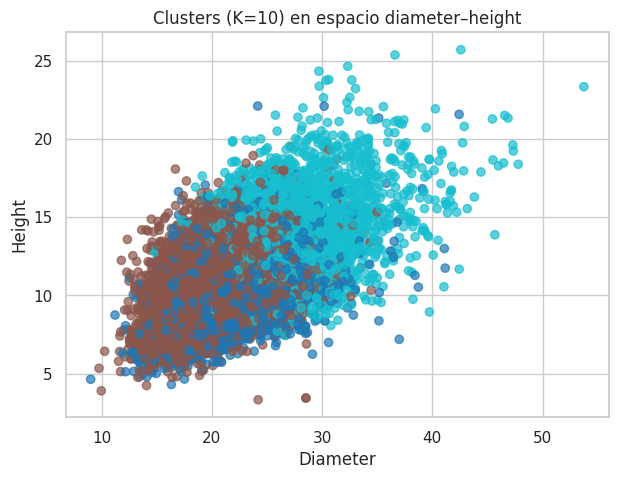

In [ ]:
# Diámetro vs altura
plt.figure()
plt.scatter(df['diameter'], df['height'], c=df['cluster'], cmap='tab10', alpha=0.7)
plt.xlabel('Diameter')
plt.ylabel('Height')
plt.title('Clusters (K=10) en espacio diameter–height')
plt.grid(True)
plt.show()

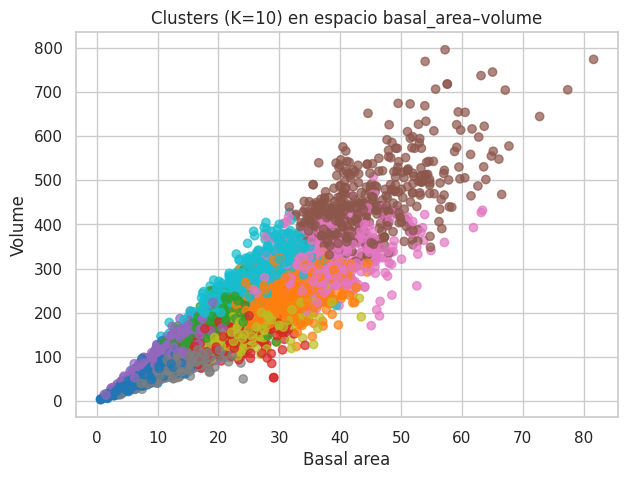

In [ ]:
# Área basal vs volumen
plt.figure()
plt.scatter(df['basal_area'], df['volume'], c=df['cluster'], cmap='tab10', alpha=0.7)
plt.xlabel('Basal area')
plt.ylabel('Volume')
plt.title('Clusters (K=10) en espacio basal_area–volume')
plt.grid(True)
plt.show()

## 9. Guardar resultados con clusters (opcional)

Se puede guardar un archivo Excel con la asignación de clusters para cada observación.

In [ ]:
output_path = '/content/drive/MyDrive/Curso-Taller_Algoritmos/data/volume_con_clusters_K10.xlsx'
df.to_excel(output_path, index=False)
print('Archivo guardado:', output_path)

Archivo guardado: /content/drive/MyDrive/Curso-Taller_Algoritmos/data/volume_con_clusters_K10.xlsx
